In [206]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


Import the LIAR dataset

In [207]:
liar_train = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)
liar_valid = pd.read_csv('liar_dataset/valid.tsv', sep='\t', header=None)
liar_test = pd.read_csv('liar_dataset/test.tsv', sep='\t', header=None)

Check columns name and rename them because they are not present in the dataset

In [208]:
print(liar_train.head())

liar_train.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue']
liar_valid.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue']
liar_test.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue']

           0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

         6           7     8     9    

Start the preprocessing of the dataset. Remove uneccessary columns:

In [209]:
liar_train_new = liar_train.drop(['id', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue'], axis=1)
liar_valid_new = liar_valid.drop(['id', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue'], axis=1)
liar_test_new = liar_test.drop(['id', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue'], axis=1)

Remove entries half-true, barely-true and mostly-true because they don't belong into the true or false category.

In [210]:
labels_to_remove = ['half-true']

liar_train_new = liar_train_new[~liar_train_new['label'].isin(labels_to_remove)]
liar_valid_new = liar_valid_new[~liar_valid_new['label'].isin(labels_to_remove)]
liar_test_new = liar_test_new[~liar_test_new['label'].isin(labels_to_remove)]

Transform pants-fire into false because it is a false statement.

In [211]:
liar_train_new['label'] = liar_train_new['label'].replace('pants-fire', 'false')
liar_valid_new['label'] = liar_valid_new['label'].replace('pants-fire', 'false')
liar_test_new['label'] = liar_test_new['label'].replace('pants-fire', 'false')

liar_train_new['label'] = liar_train_new['label'].replace('barely-true', 'false')
liar_valid_new['label'] = liar_valid_new['label'].replace('barely-true', 'false')
liar_test_new['label'] = liar_test_new['label'].replace('barely-true', 'false')

liar_train_new['label'] = liar_train_new['label'].replace('mostly-true', 'true')
liar_valid_new['label'] = liar_valid_new['label'].replace('mostly-true', 'true')
liar_test_new['label'] = liar_test_new['label'].replace('mostly-true', 'true')


Remove duplicates if present:

In [212]:
liar_train_new = liar_train_new.drop_duplicates(subset='statement')
liar_valid_new = liar_valid_new.drop_duplicates(subset='statement')
liar_test_new = liar_test_new.drop_duplicates(subset='statement')

The following function is used to clean the text. It converts the text to lowercase and removes URLs and extra spaces:
- The text is lowercased to ensure that the model does not treat the same word with different cases as different words. 
- URLs and extra spaces are removed because they do not provide any useful information for the model. 

In [213]:
def clean_text(text):
    text = text.lower() # lowercase text
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

Clean the text in the dataset:

In [214]:
liar_train_new['statement'] = liar_train_new['statement'].apply(clean_text)
liar_valid_new['statement'] = liar_valid_new['statement'].apply(clean_text)
liar_test_new['statement'] = liar_test_new['statement'].apply(clean_text)

The following function is used to fix the number format. It replaces commas in numbers ('15,000' -> '15000'):

In [215]:
def fix_number_format(text):
    text = re.sub(r'(\d),(\d)', r'\1\2', text)
    return text

Apply the fix_number_format function to the dataset:

In [216]:
liar_train_new['statement'] = liar_train_new['statement'].apply(fix_number_format)
liar_valid_new['statement'] = liar_valid_new['statement'].apply(fix_number_format)
liar_test_new['statement'] = liar_test_new['statement'].apply(fix_number_format)

Remove null lines:

In [217]:
liar_train_new = liar_train_new[liar_train_new['statement'].str.strip().astype(bool)]
liar_valid_new = liar_valid_new[liar_valid_new['statement'].str.strip().astype(bool)]
liar_test_new = liar_test_new[liar_test_new['statement'].str.strip().astype(bool)]

oversample:

In [218]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Replace 'true' and 'false' labels with numerical values
liar_train_new['label'] = liar_train_new['label'].replace({'true': 1, 'false': 0})

# Extract features (statements) and labels
X = liar_train_new['statement']
y = liar_train_new['label']

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust as needed based on dataset size
X_tfidf = vectorizer.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Convert the resampled data back to a DataFrame for inspection
resampled_features = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
liar_resampled = pd.DataFrame({
    'statement': [' '.join(words) for words in vectorizer.inverse_transform(X_resampled)],
    'label': y_resampled
})

# Replace numerical labels back to original categories
liar_resampled['label'] = liar_resampled['label'].replace({1: 'true', 0: 'false'})

# Inspect the original and resampled datasets
print("Original dataset distribution:")
print(liar_train_new['label'].value_counts())
print("\nResampled dataset distribution:")
print(liar_resampled['label'].value_counts())

liar_train_new = liar_resampled


C:\Users\Burghelea Daria\AppData\Local\Temp\ipykernel_44532\1634522820.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  liar_train_new['label'] = liar_train_new['label'].replace({'true': 1, 'false': 0})


Original dataset distribution:
label
0    4480
1    3636
Name: count, dtype: int64

Resampled dataset distribution:
label
false    4480
true     4480
Name: count, dtype: int64


Save the preprocessed dataset into a new dedicated folder:

In [219]:
liar_train_new.to_csv('preprocessed_liar/liar_train.csv', index=False)
liar_valid_new.to_csv('preprocessed_liar/liar_valid.csv', index=False)
liar_test_new.to_csv('preprocessed_liar/liar_test.csv', index=False)

Check the distribution of the text length in the training set:

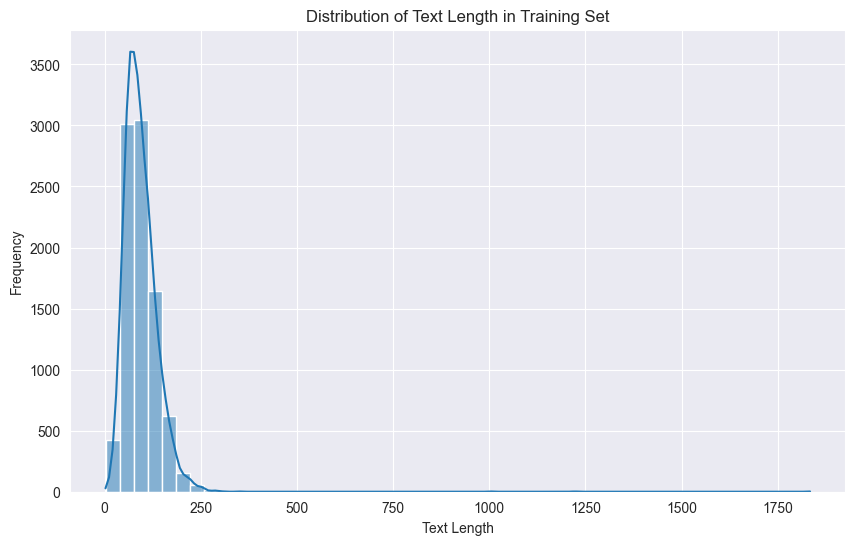

In [220]:
liar_train_new['text_length'] = liar_train_new['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(liar_train_new['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the text length in the testing set:

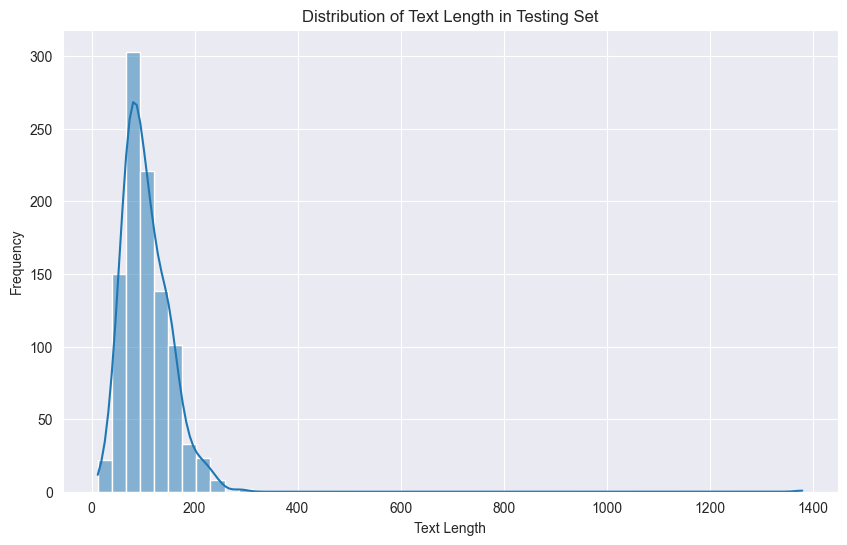

In [221]:
liar_test_new['text_length'] = liar_test_new['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(liar_test_new['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Testing Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the text length in the validation set:

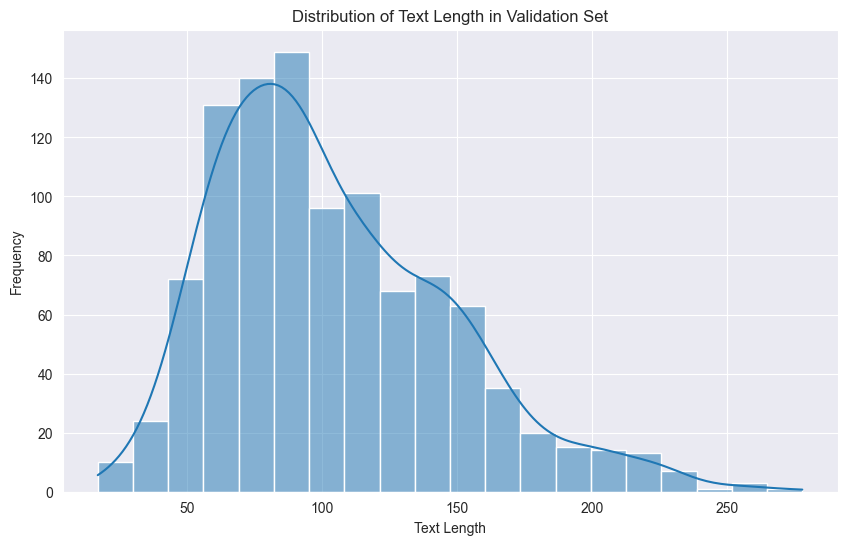

In [222]:
liar_valid_new['text_length'] = liar_valid_new['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(liar_valid_new['text_length'], bins=20, kde=True)
plt.title('Distribution of Text Length in Validation Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the class distribution in the training set:

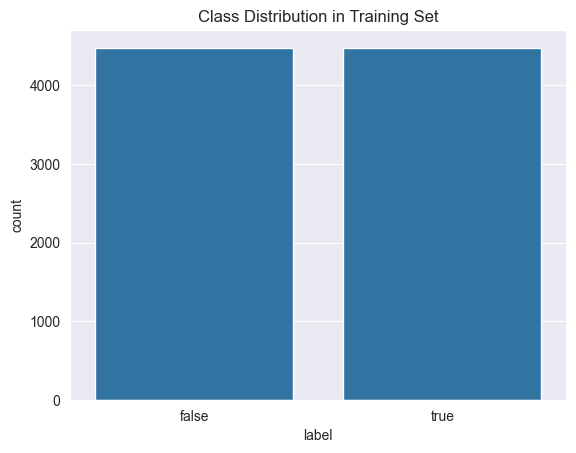

In [223]:
sns.countplot(x='label', data=liar_train_new)
plt.title('Class Distribution in Training Set')
plt.show()

Check the class distribution in the testing set:

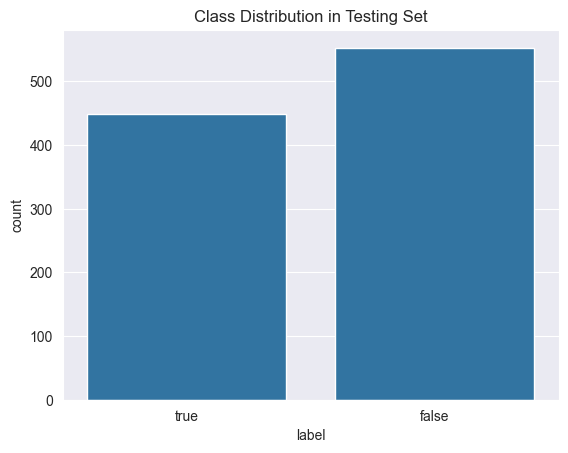

In [224]:
sns.countplot(x='label', data=liar_test_new)
plt.title('Class Distribution in Testing Set')
plt.show()

Check the class distribution in the validation set:

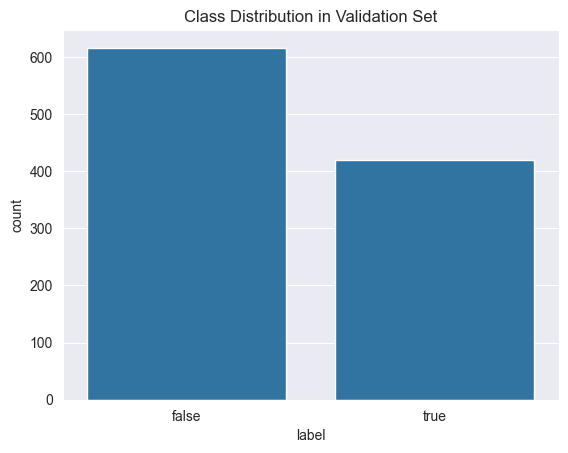

In [225]:
sns.countplot(x='label', data=liar_valid_new)
plt.title('Class Distribution in Validation Set')
plt.show()

Check the length of the text by class in the training set:

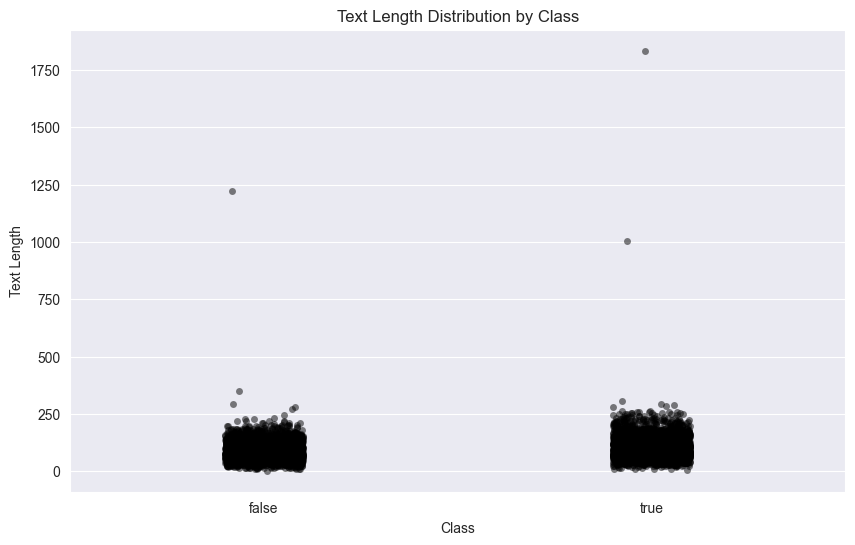

In [226]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=liar_train_new, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the length of the text by class in the testing set:

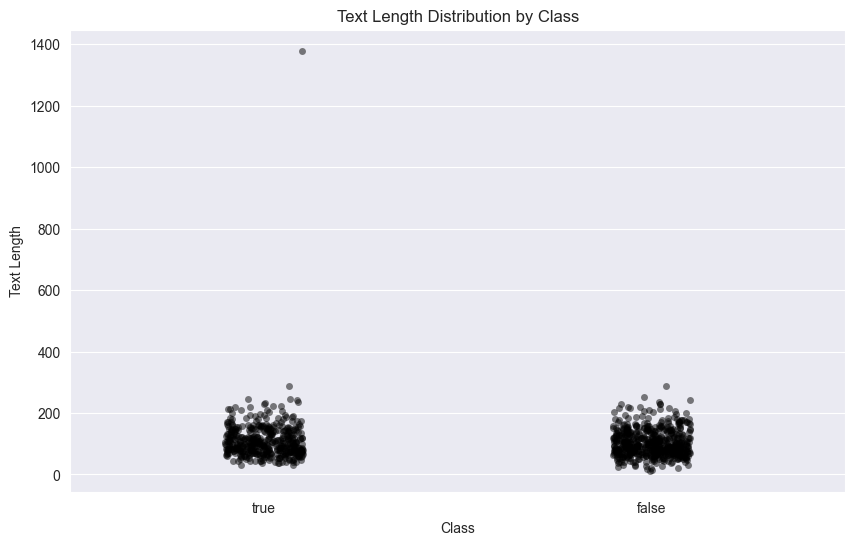

In [227]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=liar_test_new, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the length of the text by class in the validation set:

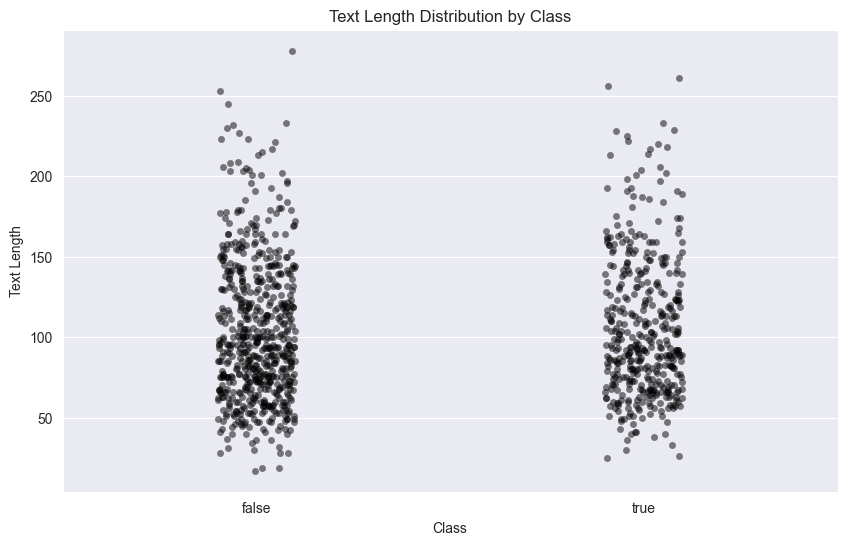

In [228]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=liar_valid_new, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the word frequency in the training set:

In [229]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))

# Transform the statements into n-gram feature vectors
X = vectorizer.fit_transform(liar_train_new['statement'])

# Get the n-grams and their frequencies
ngrams = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
ngram_freq = dict(zip(ngrams, frequencies))

# Sort and display the top 10 frequent n-grams
sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_ngram_freq)

[('says', 2157), ('percent', 933), ('state', 722), ('obama', 655), ('tax', 580), ('year', 543), ('years', 541), ('people', 520), ('states', 514), ('health', 507), ('president', 504), ('million', 443), ('care', 441), ('new', 414), ('said', 354), ('jobs', 346), ('texas', 345), ('federal', 331), ('country', 329), ('voted', 322), ('health care', 318), ('government', 313), ('barack', 311), ('taxes', 310), ('budget', 306), ('billion', 300), ('united', 286), ('pay', 277), ('law', 273), ('wisconsin', 253), ('time', 248), ('plan', 238), ('money', 230), ('united states', 222), ('rate', 215), ('american', 213), ('republican', 213), ('senate', 213), ('cut', 211), ('clinton', 209), ('10', 207), ('florida', 206), ('just', 205), ('public', 205), ('americans', 200), ('insurance', 195), ('house', 194), ('office', 191), ('income', 182), ('today', 181)]


Create a plot for the top 10 frequent words in the dataset:


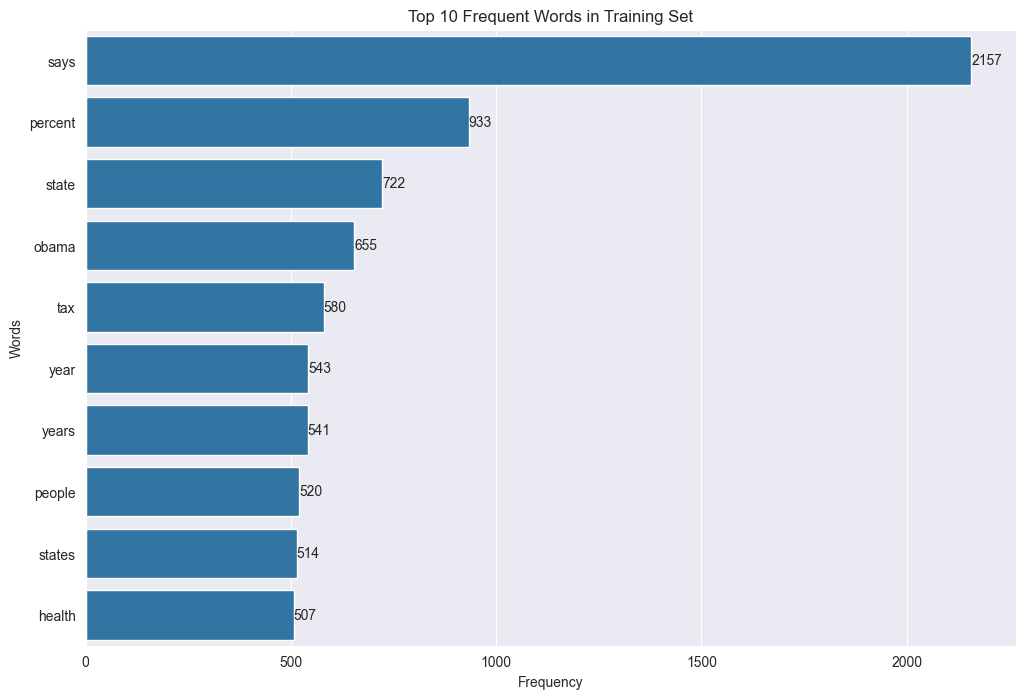

In [230]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_ngram_freq[:10]], y=[item[0] for item in sorted_ngram_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_ngram_freq[:10]]):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Frequent Words in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Check the word frequency in the testing set:

In [231]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))

# Transform the statements into n-gram feature vectors
X = vectorizer.fit_transform(liar_test_new['statement'])

# Get the n-grams and their frequencies
ngrams = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
ngram_freq = dict(zip(ngrams, frequencies))

# Sort and display the top 10 frequent n-grams
sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_ngram_freq)

[('says', 236), ('percent', 128), ('state', 85), ('obama', 80), ('tax', 69), ('president', 64), ('years', 64), ('health', 62), ('states', 60), ('year', 59), ('people', 54), ('care', 53), ('billion', 50), ('million', 48), ('federal', 46), ('barack', 45), ('health care', 44), ('new', 43), ('texas', 41), ('jobs', 39), ('barack obama', 36), ('money', 36), ('country', 35), ('government', 32), ('budget', 31), ('united', 31), ('united states', 31), ('voted', 31), ('americans', 29), ('law', 29), ('said', 28), ('public', 27), ('american', 26), ('spending', 26), ('pay', 25), ('plan', 25), ('time', 24), ('10', 23), ('clinton', 23), ('dollars', 23), ('going', 23), ('house', 23), ('republican', 23), ('children', 22), ('florida', 22), ('rate', 22), ('taxes', 22), ('congress', 21), ('debt', 21), ('president barack', 21)]


Create a plot for the top 10 frequent words in the dataset:

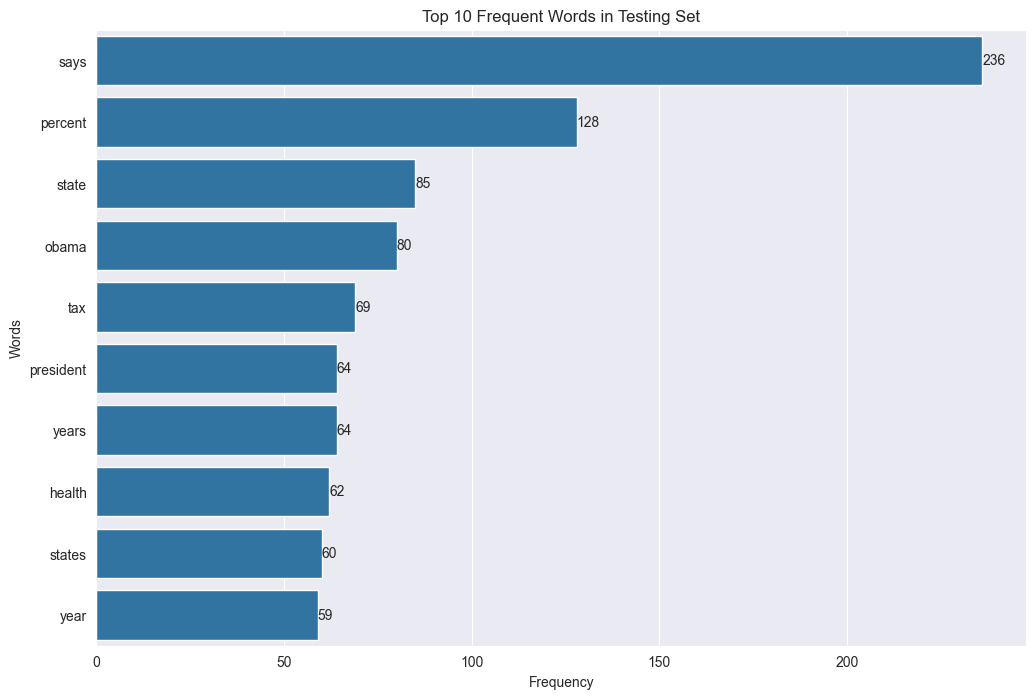

In [232]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_ngram_freq[:10]], y=[item[0] for item in sorted_ngram_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_ngram_freq[:10]]):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Frequent Words in Testing Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Check the word frequency in the validation set:

In [233]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))

# Transform the statements into n-gram feature vectors
X = vectorizer.fit_transform(liar_valid_new['statement'])

# Get the n-grams and their frequencies
ngrams = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
ngram_freq = dict(zip(ngrams, frequencies))

# Sort and display the top 10 frequent n-grams
sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_ngram_freq)

[('says', 242), ('percent', 118), ('state', 85), ('health', 84), ('obama', 82), ('care', 74), ('health care', 64), ('president', 61), ('year', 59), ('jobs', 57), ('years', 57), ('million', 52), ('new', 49), ('tax', 49), ('people', 48), ('federal', 41), ('states', 40), ('plan', 38), ('voted', 37), ('said', 36), ('barack', 35), ('budget', 35), ('government', 34), ('law', 34), ('money', 34), ('time', 32), ('spending', 30), ('texas', 30), ('debt', 29), ('gov', 28), ('obamacare', 28), ('taxes', 28), ('wisconsin', 28), ('republican', 27), ('trillion', 27), ('barack obama', 26), ('american', 25), ('insurance', 25), ('public', 25), ('americans', 24), ('billion', 24), ('country', 24), ('got', 23), ('national', 23), ('school', 23), ('america', 22), ('georgia', 22), ('going', 22), ('job', 22), ('florida', 21)]


Create a plot for the top 10 frequent words in the dataset:

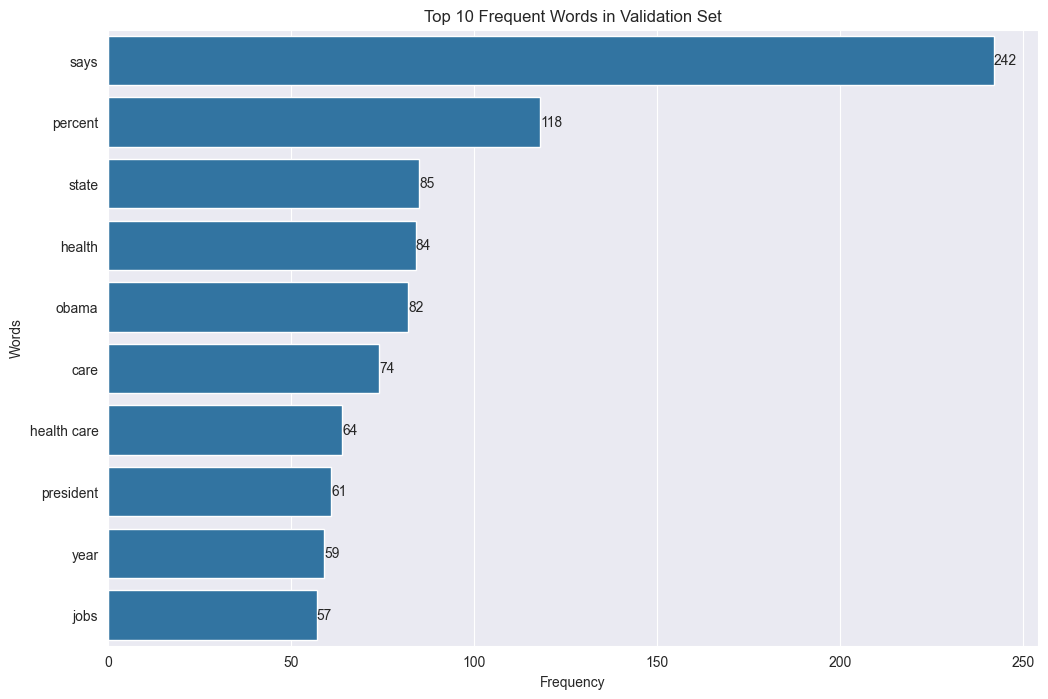

In [234]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_ngram_freq[:10]], y=[item[0] for item in sorted_ngram_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_ngram_freq[:10]]):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Frequent Words in Validation Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()